b'255'


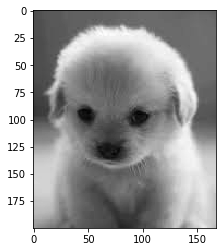

In [29]:
import numpy as np
from matplotlib import pyplot as plt

def readPGM(image_path):
    with open(image_path, "rb") as f:
        assert(f.read(1) == b'P')
        assert(f.read(1) in [b'2',b'5'])
        assert(f.read(1) == b'\n')
        #ignore comments
        byte = f.read(1)
        if(byte == b'#'):
            while(not byte == b'\n'):
                byte = f.read(1)
        #read dimentions
        width = b''
        while(not byte == b' '):
            width += byte
            byte = f.read(1)
        width = int(width.decode("utf-8"))
        height = b''
        byte = f.read(1)
        while(not byte == b'\n'):
            height += byte
            byte = f.read(1)
        height = int(height.decode("utf-8"))
        max_grayscale_value = b''
        byte = f.read(1)
        while(not byte == b'\n'):
            max_grayscale_value += byte
            byte = f.read(1)
        print(f"{max_grayscale_value}")
        array = np.empty((height, width), dtype=float)
        for row in range(0, height):
            for col in range(0, width):
                array[row, col] = int.from_bytes(f.read(1), "big")
        return array
image = readPGM("image.pgm")
plt.imshow(image, interpolation='nearest',cmap='gray')
plt.show()

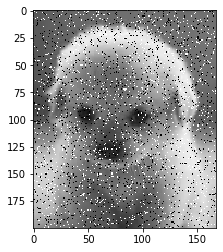

In [30]:
import random
def addNoise(matrix):
    height, width = matrix.shape
    result = np.empty(matrix.shape, dtype=float)
    for row in range(0, height):
            for col in range(0, width):
                random_int = random.randint(0, 20)
                if(random_int == 0):
                    result[row, col] = 0
                elif(random_int == 20):
                    result[row, col] = 255
                else:
                    result[row, col] = matrix[row, col]
    return result
image_with_noise = addNoise(image)
plt.imshow(image_with_noise, interpolation='nearest',cmap='gray')
plt.show()

get_pixel_with_mirror is a utility function that handles mirroring to avoid out of bounds pixel reads

In [31]:
def get_pixel_with_mirror(matrix, row, col):
    height, width = matrix.shape
    height -= 1
    width -= 1
    if(row<0):
        row = -row
    if(row>height):
        row = height - (row - height)
    if(col<0):
        col = -col
    if(col>width):
        col = width - (col - width)
    return matrix[row, col]

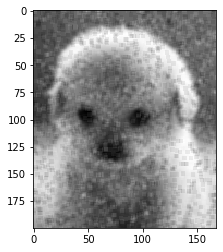

In [32]:
def filter_average(matrix, n):
    height, width = matrix.shape
    result = np.empty(matrix.shape, dtype=float)
    for row in range(0, height):
        for col in range(0, width):
            sum = 0
            divide_by = 0
            for x in range(row - n//2, row + n//2 + 1):
                for y in range(col - n//2, col + n//2 + 1):
                    divide_by += 1
                    sum += get_pixel_with_mirror(matrix, x, y)
            moy = sum / divide_by
            result[row, col] = moy
    return result
image_filtered = filter_average(image_with_noise, 4)
plt.imshow(image_filtered, interpolation='nearest',cmap='gray')
plt.show()

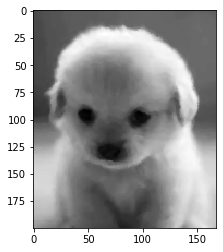

In [33]:
def filter_median(matrix, n):
    height, width = matrix.shape
    result = np.empty(matrix.shape, dtype=float)
    for row in range(0, height):
        for col in range(0, width):
            array = []
            for x in range(row - n//2, row + n//2 + 1):
                for y in range(col - n//2, col + n//2 + 1):
                    array.append(get_pixel_with_mirror(matrix, x, y))
            result[row, col] = np.median(array)
    return result
image_filtered = filter_median(image_with_noise, 4)
plt.imshow(image_filtered, interpolation='nearest',cmap='gray')
plt.show()

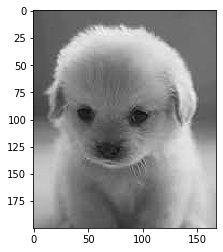

In [34]:
def filter_mask(matrix, mask):
    height, width = matrix.shape
    n, m = mask.shape
    result = np.empty(matrix.shape, dtype=float)
    for row in range(0, height):
        for col in range(0, width):
            sum = 0
            for x in range(row - n//2, row + n//2 + 1):
                for y in range(col - m//2, col + m//2 + 1):
                    mask_x = x - row + n//2
                    mask_y = y - col + m//2
                    sum += get_pixel_with_mirror(matrix, x, y)*mask[mask_x,mask_y]
            result[row, col] = sum
    return result
mask = np.array([[1, -2, 1 ],
                 [-2, 5, -2],
                 [1, -2, 1 ],])
image_sharpen = filter_mask(image, mask)
plt.imshow(image_sharpen, interpolation='nearest',cmap='gray')
plt.show()

In [35]:
import math
def signal_to_noise_ratio(original, filtered):
    original = original.flatten()
    filtered = filtered.flatten()
    original_avg = np.average(original)
    snr = math.sqrt((sum(np.square(original - original_avg)))/(sum(np.square(filtered - original))))
    return snr

In [36]:
print("Average Filter:")
best_snr = 0
best_size = 0
for mask_size in range(3,16):
    image_filtered = filter_average(image_with_noise, mask_size)
    snr = signal_to_noise_ratio(image_with_noise, image_filtered)
    if(snr > best_snr):
        best_snr = snr
        best_size = mask_size
    print(f"mask size = {mask_size}, SNR = {snr}")
print(f"mask size {best_size} gave us the highest snr value of {best_snr}")

Average Filter:
mask size = 3, SNR = 0.6860889955148278
mask size = 4, SNR = 1.4983006200240423
mask size = 5, SNR = 0.920932916563708
mask size = 6, SNR = 1.4672914643691248
mask size = 7, SNR = 1.0755799239778177
mask size = 8, SNR = 1.452670495078312
mask size = 9, SNR = 1.1733857443194167
mask size = 11, SNR = 1.2348917416060188
mask size = 13, SNR = 1.273934166611478
mask size = 15, SNR = 1.298496229691699
mask size = 17, SNR = 1.3133531917665093
mask size = 19, SNR = 1.3215736965083873
mask size = 21, SNR = 1.3251480910357036
mask size = 23, SNR = 1.3253870191354689


In [ ]:
print("Median Filter:")
best_snr = 0
best_size = 0
for mask_size in range(3,16):
    image_filtered = filter_median(image_with_noise, mask_size)
    snr = signal_to_noise_ratio(image_with_noise, image_filtered)
    if(snr > best_snr):
        best_snr = snr
        best_size = mask_size
    print(f"mask size = {mask_size}, SNR = {snr}")
print(f"mask size {best_size} gave us the highest snr value of {best_snr}")

Median Filter:
mask size = 3, SNR = 1.5237456250253885
mask size = 4, SNR = 1.4713777397052452
mask size = 5, SNR = 1.4713777397052452
mask size = 7, SNR = 1.4681459141721642
mask size = 9, SNR = 1.4657988511662747
mask size = 11, SNR = 1.4631317682507599
mask size = 13, SNR = 1.4598914890831218
mask size = 15, SNR = 1.4559825928135712
mask size 3 gave us the highest snr value of 1.5237456250253885
